In [2]:
from dispatches.models.renewables_case.RE_flowsheet import *

## Creating the Superstructure Flowsheet with Wind, PEM Electrolyzer, Battery, H2 Tank and H2 Turbine Unit Models

To create a design superstructure that contains all the technologies with which we are considering to hybridize the existing wind farm, there is the `create_model` function in `RE_flowsheet.py` which creates a Pyomo ConcreteModel for a single timestep and adds to it all the unit models, which are connected via Arcs.

This flowsheet model can be created with any of the units models excluded: the simplest flowsheet contains only the wind plant, whereas the full flowsheet contains a PEM electrolzer, battery, hydrogen storage tank, and a hydrogen turbine arranged in the below configuration:

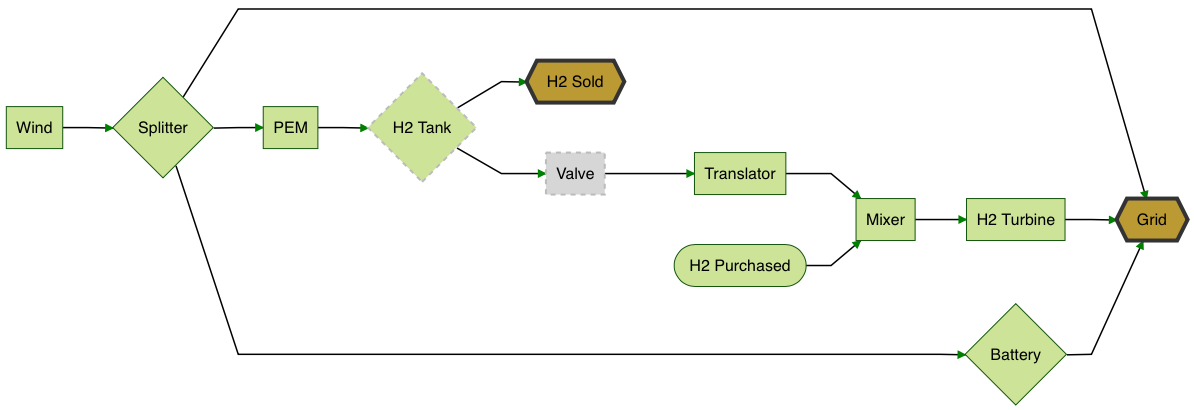

In this graph, all the green and grey nodes represent IDAES unit models whereas the tan nodes are "markets" whose sales will be optimized in the later section on Objectives. The unit models have at least a size parameter that can be optimized. The rectangular nodes are unit models with no control variables, whereas the diamond nodes have operating variables whose values need to be decided. The oval node is a slack variable that allows the hydrogen flow into the turbine to be non-zero. There are 3 different ways to model the hydrogen tank, depending on which of the grey-bordered nodes are used; see the `add_h2_tank` section below.

The `create_model` function's documentation can be found in-line with the code, and is shown below.

In [3]:
help(create_model)

Help on function create_model in module dispatches.models.renewables_case.RE_flowsheet:

create_model(wind_mw, pem_bar, batt_mw, tank_type, tank_length_m, turb_inlet_bar, wind_resource_config=None)
    Creates a Flowsheet Pyomo model that puts together the Wind unit model with optional PEM, Hydrogen Tank, and Hydrogen Turbine unit models.
    
    The input parameters determine the size of the technologies by fixing the appropriate variable. If the size parameter is None, the technology
    will not be added.
    
    The wind is first split among its output destinations: grid, battery and PEM with an ElectricalSplitter unit model. 
    After the PEM, a tank and turbine may be added. The `simple` tank model includes outlet ports for hydrogen flows to the turbine and the pipeline.
    The `detailed` tank model uses a Splitter unit model to split the material and energy flows to the turbine and to hydrogen sales.
    
    Args:
        wind_mw: wind farm capacity
        pem_bar: operati

The `create_model` function uses individual functions to add each unit model separately. Each of these individual functions has input parameters of size and sometimes an operating condition such as pressure. The unit models added to the flowsheet are created with a fixed size and operating condition, and these constraints or fixed values will be relaxed in later steps to allow those variables to be optimized.

The formulation of each of these models is described in the [DISPATCHES Documentation](https://dispatches.readthedocs.io/en/main/models/index.html)

In [4]:
# https://dispatches.readthedocs.io/en/main/models/renewables/wind_power.html
help(add_wind)

Help on function add_wind in module dispatches.models.renewables_case.RE_flowsheet:

add_wind(m, wind_mw, wind_resource_config=None)
    Adds a wind unit to the flowsheet with a fixed system capacity and that uses resource data to determine the capacity factors
    
    The resource data can be provided by configuring either `resource_speed` or `resource_probability_density`.
    The `resource_speed` is a list of wind speeds (m/s) per timestep of the flowsheet.
    The `resource_probability_density` is formatted as a 2d list where each row contains: (wind m/s, wind degrees from north clockwise, probability) 
    and the probabilities in all rows add up to 1.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        wind_mw: capacity of wind model to be fixed
        wind_resource_config: dictionary of Windpower Config keys (`resource_speed`, `resource_probability_density`) and ConfigValues
    Returns:
        wind unit model in the flowsheet



In [5]:
# https://dispatches.readthedocs.io/en/main/models/renewables/pem_electrolyzer.html
help(add_pem)

Help on function add_pem in module dispatches.models.renewables_case.RE_flowsheet:

add_pem(m, outlet_pressure_bar)
    Adds a PEM electrolyzer unit to the flowsheet with a fixed outlet pressure and conversion rate. The properties package is h2_ideal_vap.
    
    The operating temperature and maximum pressure of the PEM are pulled from load_parameters.py
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        outlet_pressure_bar: operating pressure of the PEM
    Returns:
        PEM electrolyzer unit model in the flowsheet
        h2_ideal_vap property package in the flowsheet



In [6]:
# https://dispatches.readthedocs.io/en/main/models/renewables/battery.html
help(add_battery)

Help on function add_battery in module dispatches.models.renewables_case.RE_flowsheet:

add_battery(m, batt_mw)
    Adds a Battery unit to the flowsheet with a fixed power and duration of 4 hours.
    
    The charging and discharging efficiencies are set at 98%.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        batt_mw: nameplate power
    Returns:
        battery unit model in flowsheet



In [7]:
# Detailed Tank: https://dispatches.readthedocs.io/en/main/models/nuclear/hydrogen_tank.html
# Simplified Tank: 
help(add_h2_tank)

Help on function add_h2_tank in module dispatches.models.renewables_case.RE_flowsheet:

add_h2_tank(m, tank_type='simple', valve_outlet_bar=None, length_m=None)
    Adds a Hydrogen Tank unit to the flowsheet, with 3 options for the model type: `simple`, `detailed` and `detailed-valve`.
    
    For the `simple` type, the model is linear with no energy balances.
    For the `detailed` type, the model is nonlinear with energy balances deactivated. The capacity of the tank is determined by its 
    geometry.
    For the `detailed-valve` type, the `detailed` model is used, but with energy balances active and with a Valve unit. 
    The valve coefficient is pulled from load_parameters but needs to be be tuned per application.
    
    Args:
        m: existing ConcreteModel with a flowsheet `fs`
        tank_type: `simple`, `detailed`, or `detailed-valve`
        valve_outlet_bar: required if not using `simple` type, outlet pressure of the valve
        length_m: required if using `detailed

In [8]:
# https://dispatches.readthedocs.io/en/main/models/nuclear/hydrogen_turbine.html
help(add_h2_turbine)

Help on function add_h2_turbine in module dispatches.models.renewables_case.RE_flowsheet:

add_h2_turbine(m, inlet_pres_bar)
    Adds a hydrogen turbine unit to the flowsheet, using the h2_reaction_props property package.
    
    A translator and mixer unit is added also. The mixer adds an `air_feed` and an `purchased_hydrogen_feed` to the `hydrogen_feed`.
    The air_feed contains oxygen at a fixed ratio relative to the inlet hydrogen flow rate, `air_h2_ratio`, from load_parameters.
    .The purchased_hydrogen_feed allows the turbine hydrogen inlet flow rate to be `h2_turb_min_flow`, which helps
    with the model solve.
    
    The `compressor_dp` is fixed from load_parameters, the compressor's isentropic efficiency is 0.86, 
    the stoichiometric conversion rate of hydrogen is 0.99, and the turbine's isentropic efficiency is 0.89.
    
    The turbine's `electricity` is an Expression taking the difference between the turbine's and compressor's work.
    
    Args:
        m: exis

In [9]:
# Example flowsheet creation

wind_mw = 200
pem_bar = 1.01325
batt_mw = 50
tank_type = "simple"
h2_turb_bar = 24.7
tank_length_m = None
wind_resource_speed = { 'resource_speed': 10 }

m = create_model(wind_mw, pem_bar, batt_mw, tank_type, tank_length_m, h2_turb_bar, wind_resource_config=wind_resource_speed)

m.fs.battery.report()


Unit : fs.battery                                                          Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                               Inlet  Outlet   kWh 
    electricity               0.0000  0.0000      -
    initial_state_of_charge        -       - 0.0000
    initial_energy_throughput      -       - 0.0000
    state_of_charge                -       - 0.0000
    energy_throughput              -       - 0.0000


## Linking Flowsheets into a Dynamic Model with MultiPeriod Model

The `MultiPeriodModel` class is used to link flowsheet models representing a single time point into sequential periods of time. Each time point is created by the `wind_battery_pem_tank_turb_model`, and dynamic state variables such as battery state of charge and hydrogen tank material (and energy) holdups are linked from one time period to the next with `wind_battery_pem_tank_turb_variable_pairs` and from the last to the first time period with `wind_battery_pem_tank_turb_periodic_variable_pairs`.

The `wind_battery_pem_tank_turb_model` function creates the model using `create_model` with input parameter dictionary defining size and operating variables including the `wind_mw`, `pem_bar`, `tank_type`, `tank_size`, `pem_bar` and wind resource. The sizes are initial guesses for the optimal design and are unfixed during the optimization process, while the operating variables are fixed, currently.

The operating PEM pressure used is 1.01325 bar and the operating pressure is 300 K. The produced hydrogen is at this state when it flows into the tank. The simple tank model doesn't track pressure and temperature and while the detailed tank model does, it does not model the energy required to compress the hydrogen. The hydrogen leaves the tank at 1.01325 bar and 300 K and enters the Mixer with an `air_feed` and a `purchased_hydrogen_feed`, this latter feed is simply to allow the minimum flow rate of hydrogen into the turbine, `h2_turb_min_flow`, to be greater than zero. The Air feed has a ratio of 10.76 to the hydrogen feed. The hydrogen turbine's change in pressure is 24.01 bar, and the outlet material is at 1.01325 bar.

After the model is created, the model is initialized via `initialize_fs`. The initialization was designed to be applicable to all time points in the multiperiod model, and results in an initial state of the multiperiod model that is internally consistent, e.g. has little infeasibility. This initial state requires dynamic state variables are equal across time periods, and so during initialization, no energy flows through the battery and no hydrogen accumulates in the tank. Instead, all electricity from the wind flows to the grid.

Finally, operating constraints and cost components are added to the model. The battery ramp rate is currently practically unconstrained, with `battery_ramp_rate` at 1e5 mWh/hr.

In [10]:
from dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP import *

help(wind_battery_pem_tank_turb_variable_pairs)
help(wind_battery_pem_tank_turb_periodic_variable_pairs)

Help on function wind_battery_pem_tank_turb_variable_pairs in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_variable_pairs(m1, m2, tank_type)
    This function links together unit model state variables from one timestep to the next.
    
    The hydrogen tank and the battery model have material and energy holdups that need to be consistent across time blocks.
    If using the `simple` tank model, there are no energy holdups to account for. For the `detailed` tank model, the emergy
    holdups need to be linked.
    
    Args:
        m1: current time block model
        m2: next time block model
        tank_type: `simple`, `detailed` or `detailed-valve`

Help on function wind_battery_pem_tank_turb_periodic_variable_pairs in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_periodic_variable_pairs(m1, m2, tank_type)
    The final hydrogen material holdup and battery storage o

In [11]:
help(wind_battery_pem_tank_turb_model)

print("Cost Parameters:")
print(f"Wind Capital Cost\t\t\t{wind_cap_cost} $/kW")
print(f"Wind Fixed Operating Cost\t\t{wind_op_cost} $/kW-yr")
print(f"Battery Capital Cost\t\t\t{batt_cap_cost} $/kW")
print(f"PEM Capital Cost\t\t\t{pem_cap_cost} $/kW")
print(f"PEM Fixed Operating Cost\t\t{pem_op_cost} $/kW-yr")
print(f"PEM Variable Operating Cost\t\t{pem_var_cost} $/kWh")
print(f"Tank Capital Cost\t\t\t{tank_cap_cost_per_kg} $/kg")
print(f"Tank Fixed Operating Cost\t\t{tank_op_cost} $/kg-yr")
print(f"Turbine Capital Cost\t\t\t{turbine_cap_cost} $/kW")
print(f"Turbine Fixed Operating Cost\t\t{turbine_op_cost} $/kW-yr")
print(f"Turbine Variable Operating Cost\t\t{turbine_var_cost} $/kWh")


Help on function wind_battery_pem_tank_turb_model in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_model(wind_resource_config, input_params, verbose)
    Creates an initialized flowsheet model for a single time step with operating, size and cost components
    
    First, the model is created using the input_params and wind_resource_config
    Second, the model is initialized so that it solves and its values are internally consistent
    Third, battery ramp constraints and operating cost components are added
    
    Args:
        wind_resource_config: wind resource for the time step
        input_params: size and operation parameters. Required keys: `wind_mw`, `pem_bar`, `batt_mw`, `tank_type`, `tank_size`, `pem_bar`
        verbose:

Cost Parameters:
Wind Capital Cost			1550 $/kW
Wind Fixed Operating Cost		43 $/kW-yr
Battery Capital Cost			1200 $/kW
PEM Capital Cost			1630 $/kW
PEM Fixed Operating Cost		47.9 $/kW-yr
PEM Variab

In [12]:
wind_resource_speed = { 'resource_speed': 10 }
                 
input_params = {
    "wind_mw": wind_mw,
    "wind_mw_ub": wind_mw_ub,
    "batt_mw": fixed_batt_mw,
    "pem_mw": fixed_pem_mw,
    "pem_bar": pem_bar,
    "pem_temp": pem_temp,
    "tank_size": fixed_tank_size,
    "tank_type": "simple",
    "turb_mw": turb_p_mw,

    "wind_resource": wind_resource_speed,
    "h2_price_per_kg": h2_price_per_kg,
    "DA_LMPs": prices_used,

    "design_opt": True,
    "extant_wind": True
}
                 
m = wind_battery_pem_tank_turb_model(wind_resource_speed, input_params, verbose=False)

# Display the current initialized state of the flowsheet

m.fs.windpower.display()
m.fs.splitter.report()
m.fs.battery.report()
m.fs.pem.report()
m.fs.h2_tank.display()
m.fs.h2_turbine.report()

2022-06-17 15:31:02 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
Block fs.windpower

  Variables:
    system_capacity : Rated system capacity of wind farm
        Size=1, Index=None, Units=kW
        Key  : Lower : Value    : Upper : Fixed : Stale : Domain
        None :     0 : 200000.0 :  None :  True :  True : NonNegativeReals
    electricity : Electricity production
        Size=1, Index=fs._time, Units=kW
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
        0.0 :     0 : 120333.55002771995 :  None : False :  True : NonNegativeReals

  Objectives:
    None

  Constraints:
    elec_from_capacity_factor : Size=1
        Key : Lower : Body : Upper
        0.0 :   0.0 :  0.0 :   0.0

Unit : fs.splitter                                                         Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                   Inlet     O

The Multiperiod model is constructed for 7 time points as shown below:

In [13]:
tank_type = 'simple'
input_params['wind_resource'] = {t:
                                    {'wind_resource_config': {
                                         'resource_speed': [wind_speeds[t]]
                                    }
                                } for t in range(7)}
                                
mp_model = MultiPeriodModel(n_time_points=7,
                            process_model_func=partial(wind_battery_pem_tank_turb_mp_block, input_params=input_params, verbose=False),
                            linking_variable_func=partial(wind_battery_pem_tank_turb_variable_pairs, tank_type=tank_type),
                            periodic_variable_func=partial(wind_battery_pem_tank_turb_periodic_variable_pairs, tank_type=tank_type))
mp_model.build_multi_period_model(input_params['wind_resource'])

2022-06-17 15:31:03 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.


## Optimizing for Net Present Value

For the design optimization, the "historical" Locational Marginal Price for the Day-Ahead market for the RTS-GMLC is used as the price signal and the hybrid system is operated as a "price taker". The price taker assumption is that the LMPs of the electricity market will stay steady regardless of the energy production of the system. This assumption will be removed in the double-loop simulation below, in which the energy system is co-simulated within the production cost model, and the actual dispatch and revenue of the system can be evalluated.

In the following example, we run a design optimization with an existing 200 MW wind farm, with a hydrogen price of $2.0/kg, using the first 7 days of Day Ahead Market prices. These prices are results from a full year simulation of the RTS-GMLC with Prescient.

The function `wind_battery_pem_tank_turb_optimize` creates the MultiPeriodModel and adds the size and operating constraints in addition to the Net Present Value Objective. The NPV is a function of the capital costs, the electricity market profit, the hydrogen market profit, and the capital recovery factor. The operating decisions and state evolution of the unit models and the flowsheet as a whole form the constraints of the Non-linear Program.

$$
\begin{align}
\max_{S_{i \in I}} \:
    & -\Sigma_{i \in I}C_{i} & & \\
    & + \big[ \Sigma_t  P_{lmp, t} * (E_{splitter, t} + E_{batt, t} +E_{turb, t}) - (O_{wind, t} + O_{pem, t} + O_{tank, t} + O_{turb, t}) \\
    & + \big( P_{h2, t} * (F_{sold, t} - F_{purchased, t}) \big) \big] \\
    & * 52.143 / n_{weeks} / CRF \\
    \\
st \;\;
    & g_n(S, P, E, F) \leq 0 \\
    & h_m(S, P, E, F, O) = 0
\end{align}
$$

$I = [wind, batt, pem, tank, turb]$ is the set of technologies

$S_i$ is the size of technology $i$

$C_{i}$ is the total installed cost of a technology

$P_{lmp, t}$ and $P_{h2, t}$ are market prices at time $t$

$O_{i, t}$ is the total operating cost of a technology for a single time step

$F_{sold, t}$ and $F_{purchased, t}$ are flows of hydrogen to and from the market

$n_{weeks}$ is the number of weeks in the MultiPeriod Model.


There are two settings for the optimization:

`design_opt`: If true, the size variables are free to be optimized, otherwise the sizes are fixed at the initial guess sizes.

`extant_wind`: If true, assume the wind plant already exists, so fix the wind size to the initial size and do not add wind capital cost to NPV.

Help on function wind_battery_pem_tank_turb_optimize in module dispatches.models.renewables_case.wind_battery_PEM_tank_turbine_LMP:

wind_battery_pem_tank_turb_optimize(n_time_points, input_params, verbose=False, plot=False)
    The main function for optimizing the flowsheet's design and operating variables for Net Present Value. 
    
    Creates the MultiPeriodModel and adds the size and operating constraints in addition to the Net Present Value Objective.
    The NPV is a function of the capital costs, the electricity market profit, the hydrogen market profit, and the capital recovery factor.
    The operating decisions and state evolution of the unit models and the flowsheet as a whole form the constraints of the Non-linear Program.
    
    Required input parameters include:
        `wind_mw`: initial guess of the wind size
        `wind_mw_ub`: upper bound of wind size
        `batt_mw`: initial guess of the battery size
        `pem_mw`: initial guess of the pem size
        `pe

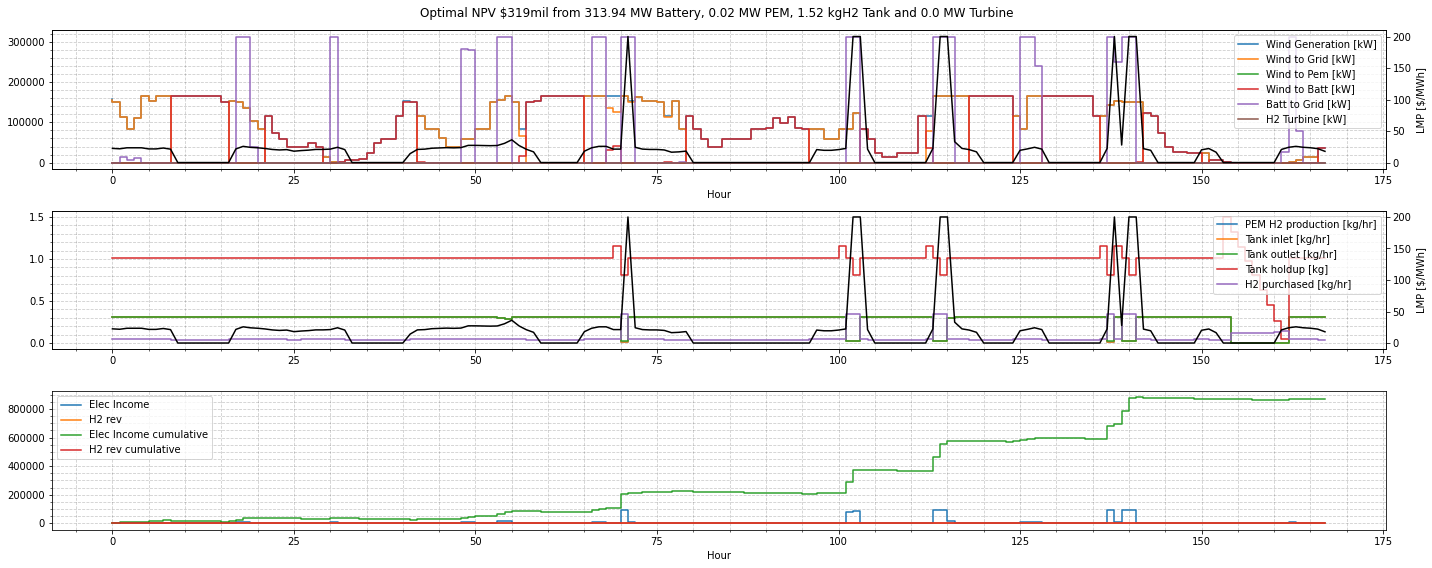

In [14]:
help(wind_battery_pem_tank_turb_optimize)
default_input_params['wind_mw'] = wind_mw
design_res = wind_battery_pem_tank_turb_optimize(n_time_points=7 * 24, input_params=default_input_params, verbose=False, plot=True)

## Interpreting the Conceptual Design Results

The results show that for an existing wind plant of 200 MW, the best NPV is \\$319B from a 314 MW 4-hr battery (the 0.02 MW PEM electrolyzer and 1.52 kgH2 tank should both be considered as 0). The timeseries on the first plot shows two x-axes: the plant's powerflows in kW on the left with colored lines and the LMP signal in \\$/MWh on the right in the black line. The second plot shows the hydrogen flows, and in this design, since the PEM is nearly 0, there is minimal activity with hydrogen. The third plot shows the hourly and cumulative revenues for the electricity and hydrogen markets. 

The optimal design gives a very large battery size, and there are several reasons for this result. The first is that the pricetaker perspective does not account for the depth of the energy market at any time point, and whether prices would be supressed (or increased) by all the battery discharging (or charging), nor whether the battery would even be scheduled to dispatch at its desired times. The second is that this analysis is using only the first week of the year, during which there is high wind production relative to the rest of the year, and extrapolating those conditions to a 30-year project lifetime. Using a full year's data will increase the representativeness of the power and price profiles. Finally, the result is highly dependent on the cost and price assumptions, the most uncertain of them being the LMP time series but also the price of hydrogen has a large impact on the relative benefits of electricity vs hydrogen production.

The design optimization was simulated across a few hydrogen prices and time horizons, and the results are shown and plotted below. While the table does not have results for the full factorial design of the 3 hydrogen prices and the 6 time horizons, it does give an idea of the variance of the optimal design. 

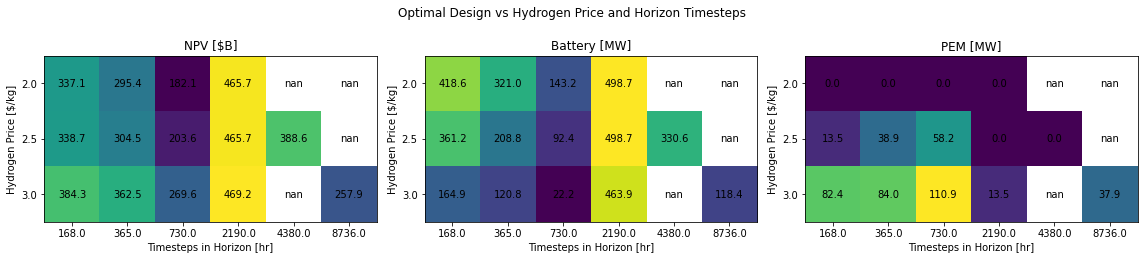

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.read_csv("ConceptualDesignResults.csv")

all_ts = np.sort(res_df['ts'].unique())
all_hp = np.sort(res_df['h2_price'].unique())

X, Y = np.meshgrid(all_ts, all_hp)
NPV = []
B = []
P = []
for x, y in zip(X.ravel(), Y.ravel()):
    z = res_df.query(f'ts == {x} and h2_price == {y}')
    NPV.append(z.NPV.values[0] if len(z) else np.NaN)
    B.append(z.batt_mw.values[0] if len(z) else np.NaN)
    P.append(z.pem_mw.values[0] if len(z) else np.NaN)
NPV = np.array(NPV).reshape(X.shape) * 1e-6
B = np.array(B).reshape(X.shape)
P = np.array(P).reshape(X.shape)

def plot_heatmap(ax, Z, title):
    im = ax.imshow(Z, cmap='viridis')
    ax.set_xticks(range(6))
    ax.set_xticklabels(all_ts)
    ax.set_xlabel("Timesteps in Horizon [hr]")
    ax.set_yticks(range(3))
    ax.set_yticklabels(all_hp)
    ax.set_ylabel("Hydrogen Price [$/kg]")
    # plt.colorbar(im, ax=ax, location='bottom')
    for (i, j), z in np.ndenumerate(Z):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))
plot_heatmap(ax[0], NPV, "NPV [$B]")
plot_heatmap(ax[1], B, "Battery [MW]")
plot_heatmap(ax[2], P, "PEM [MW]")
plt.suptitle("Optimal Design vs Hydrogen Price and Horizon Timesteps")
plt.tight_layout()